In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import pickle
from time import time

from consav import linear_interp

import LimitedCommitmentModel as lcm

# plot style
linestyles = ['-','--','-.',':',':','-','-.']
markers = ['o','s','D','*','P','o','s']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
do_egm = True
threads = 24

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

In [2]:
# compile c++ files
if do_cpp & do_compile:
    model = lcm.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)
    model.cpp.delink()

# Solve and simulate from alternative models

In [3]:
# settings for models to solve
T = 20
sigma = 0.1
num_love = 21
num_A = 50
num_A_pd = 50

uniform_mat = np.ones((num_A,num_A))/num_A

settings = { 
       'p_meet': 0.1, 
       'div_A_share': 0.5, 
       'sigma_love':sigma,
       'T':T,'do_cpp':do_cpp,
       'threads':threads, 
       'interp_power':False,
       'num_love': num_love, 
       'do_egm':True, 
       'num_A': num_A_pd, 
       'num_A_pd':num_A_pd,
       'num_Ctot':50,
       'simT':T,
       'simN': 500,
       }


solution_specs = {'solution': {'latexname':'Solution', 'par':{**settings, 'do_egm':False, 'num_A': 250, 'num_Ctot':250, 'num_power':101, 'num_love':101}}}

num_margu = 25

specs = {
    'model 1':{'latexname':'VFI', 'par':{**settings, 'use_external_solution':True, 'do_egm':False}},
    'model 2':{'latexname':f'iEGM c{num_margu} linear', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':num_margu}},
    'model 3':{'latexname':'iEGM c100 linear', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':100}},
    'model 4':{'latexname':f'iEGM c{num_margu}, linear inverse', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':num_margu, 'interp_inverse': True}},
    'model 5':{'latexname':'iEGM c100 linear inverse', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':100, 'interp_inverse': True}},
#     'model 6':{'latexname':'iEGM numerical inverse', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':100, 'interp_method': "numerical"}},
#     'model 7':{'latexname':'iEGM numerical inverse, interpolate', 'par':{**settings, 'use_external_solution':True, 'interp_intra_period_in_num_inverse':True, 'num_marg_u':100, 'interp_method': "numerical"}},
    }


In [4]:
# solve/load solution Marginal values
do_load = True
do_save = False
do_solve = False

if do_solve:
    model_solution = lcm.HouseholdModelClass(par=solution_specs['solution']['par'])

    print('Linking to c++')
    model_solution.link_to_cpp(force_compile=False)

    print('Solving solution model')
    %time model_solution.solve()

    model_solution.cpp.compute_margEV(model_solution.sol, model_solution.par)

    EmargV_start_as_couple_true = model_solution.sol.EmargV_start_as_couple
    EmargVw_start_as_single_true = model_solution.sol.EmargVw_start_as_single
    EmargVm_start_as_single_true = model_solution.sol.EmargVm_start_as_single
    grid_A_true = model_solution.par.grid_A
    grid_power_true = model_solution.par.grid_power
    grid_love_true = model_solution.par.grid_love

    margV_list = [EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true]

    ## saveobject in pickle
    if do_save:
        with open('output/solution_margV.pkl', 'wb') as f:
            pickle.dump(margV_list, f)
        print('Saved solution margVs')

if do_load:
    with open('output/solution_margV.pkl', 'rb') as f:
        EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true = pickle.load(f)
    print('Loaded solution margVs')


Loaded solution margVs


In [5]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'\nsolving {spec["latexname"]}...')
    
    # setup model
    models[name] = lcm.HouseholdModelClass(name=name,par=spec['par'])
    models[name].par.seed = 0
    models[name].allocate()

    if models[name].par.use_external_solution:
        print("Set external solution for computing Euler Errors")
        models[name].set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

        
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec

    # # solve
    %time models[name].solve()

    # simulate
    print(f'Simulating {spec["latexname"]}...')
    %time models[name].simulate()
    print(f'Mean log10 euler error: {models[name].sim.mean_log10_euler}')




solving VFI...
Set external solution for computing Euler Errors
CPU times: total: 44.9 s
Wall time: 2.46 s
Simulating VFI...
CPU times: total: 36.7 s
Wall time: 2.02 s
Mean log10 euler error: [-5.05579159]

solving iEGM c25 linear...
Set external solution for computing Euler Errors
CPU times: total: 4.05 s
Wall time: 215 ms
Simulating iEGM c25 linear...
CPU times: total: 0 ns
Wall time: 3.99 ms
Mean log10 euler error: [nan]

solving iEGM c100 linear...
Set external solution for computing Euler Errors


e:\AMO\Projects\iEGM\LimitedCommitmentModel.py:410: RuntimeWarning: Mean of empty slice
  sim.mean_log10_euler[0] = np.nanmean(np.log10( abs(sim.euler[couple]/sim.C_tot[couple]) + 1.0e-16)) + np.nanmean(np.log10( abs(sim.euler[single]/sim.Cw_tot[single]) + 1.0e-16))


CPU times: total: 5.39 s
Wall time: 273 ms
Simulating iEGM c100 linear...
CPU times: total: 37.2 s
Wall time: 2.03 s
Mean log10 euler error: [-4.47674688]

solving iEGM c25, linear inverse...
Set external solution for computing Euler Errors
CPU times: total: 3.88 s
Wall time: 212 ms
Simulating iEGM c25, linear inverse...
CPU times: total: 35.4 s
Wall time: 1.92 s
Mean log10 euler error: [-4.61034752]

solving iEGM c100 linear inverse...
Set external solution for computing Euler Errors
CPU times: total: 5.25 s
Wall time: 280 ms
Simulating iEGM c100 linear inverse...
CPU times: total: 33.4 s
Wall time: 1.91 s
Mean log10 euler error: [-4.99145902]


In [6]:
m1 = models['model 1']
m2 = models['model 2']
m3 = models['model 3']
m4 = models['model 4']
m5 = models['model 5']

In [7]:
def test_euler_errors(min_grid, max_grid, step, use_external_solution=True, init_A=2.0):
    num_marg_u = {'interp linear inverse':[], 'interp linear':[]}
    euler_error = {'interp linear inverse':[], 'interp linear':[]}
    EmargV_start_as_couple = {'interp linear inverse':[], 'interp linear':[]}

    for iC in range(min_grid,max_grid,step):
        print(f'Computing Euler Error for iEGM c{iC}...')
        model = lcm.HouseholdModelClass(par={**settings, 'num_marg_u':iC, 'interp_inverse': True, 'use_external_solution':use_external_solution})
        model.set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)
        model.link_to_cpp(force_compile=False)
        model.solve()
        model.sim.init_A[:] = init_A
        model.simulate()
        num_marg_u['interp linear inverse'].append(iC)
        euler_error['interp linear inverse'].append(model.sim.mean_log10_euler[0])
        EmargV_start_as_couple['interp linear inverse'].append(model.sol.EmargV_start_as_couple)

        model.par.interp_inverse = False
        model.allocate()
        model.set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)
        model.solve()
        model.sim.init_A[:] = init_A
        model.simulate()
        num_marg_u['interp linear'].append(iC)
        euler_error['interp linear'].append(model.sim.mean_log10_euler[0])
        EmargV_start_as_couple['interp linear'].append(model.sol.EmargV_start_as_couple)

    # sort list
    num_marg_u['interp linear inverse'], euler_error['interp linear inverse'] = zip(*sorted(zip(num_marg_u['interp linear inverse'], euler_error['interp linear inverse'])))
    num_marg_u['interp linear'], euler_error['interp linear'] = zip(*sorted(zip(num_marg_u['interp linear'], euler_error['interp linear'])))
    return num_marg_u, euler_error, EmargV_start_as_couple

In [8]:
num_marg_u_true, euler_error_true, EmargV_start_as_couple = test_euler_errors(15, 100,5, use_external_solution=True,init_A=2.0)

Computing Euler Error for iEGM c15...
Computing Euler Error for iEGM c20...
Computing Euler Error for iEGM c25...
Computing Euler Error for iEGM c30...
Computing Euler Error for iEGM c35...
Computing Euler Error for iEGM c40...
Computing Euler Error for iEGM c45...
Computing Euler Error for iEGM c50...
Computing Euler Error for iEGM c55...
Computing Euler Error for iEGM c60...
Computing Euler Error for iEGM c65...
Computing Euler Error for iEGM c70...
Computing Euler Error for iEGM c75...
Computing Euler Error for iEGM c80...
Computing Euler Error for iEGM c85...
Computing Euler Error for iEGM c90...
Computing Euler Error for iEGM c95...


Text(0.5, 1.0, 'Euler error using external expected marginal, init_A=2.0')

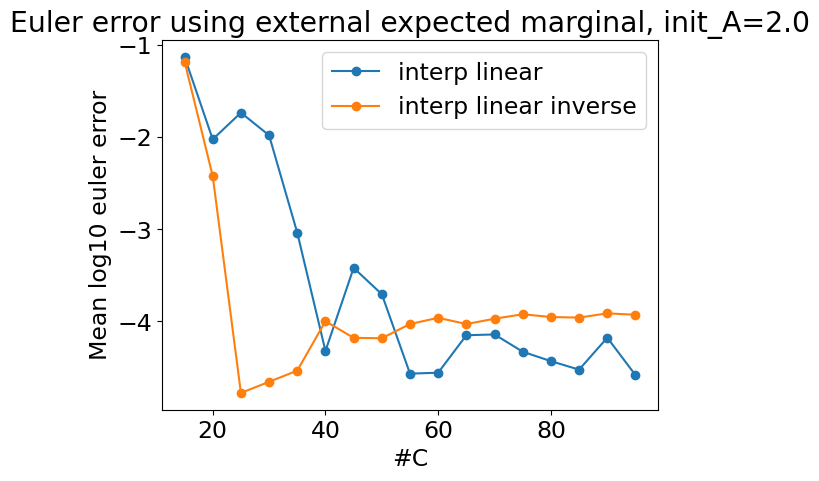

In [9]:
plt.plot(num_marg_u_true['interp linear'], euler_error_true['interp linear'], label='interp linear', marker='o')
plt.plot(num_marg_u_true['interp linear inverse'], euler_error_true['interp linear inverse'], label='interp linear inverse', marker='o')
plt.legend()
plt.ylabel('Mean log10 euler error')
plt.xlabel('#C')
plt.title('Euler error using external expected marginal, init_A=2.0')

In [11]:
num_marg_u_true0, euler_error_true0, EmargV_start_as_couple0 = test_euler_errors(15, 100,5, use_external_solution=True,init_A=0.0)

Computing Euler Error for iEGM c15...
Computing Euler Error for iEGM c20...
Computing Euler Error for iEGM c25...
Computing Euler Error for iEGM c30...
Computing Euler Error for iEGM c35...
Computing Euler Error for iEGM c40...
Computing Euler Error for iEGM c45...
Computing Euler Error for iEGM c50...
Computing Euler Error for iEGM c55...
Computing Euler Error for iEGM c60...
Computing Euler Error for iEGM c65...
Computing Euler Error for iEGM c70...
Computing Euler Error for iEGM c75...
Computing Euler Error for iEGM c80...
Computing Euler Error for iEGM c85...
Computing Euler Error for iEGM c90...
Computing Euler Error for iEGM c95...


Text(0.5, 1.0, 'Euler error using external expected marginal, init_A=0.0')

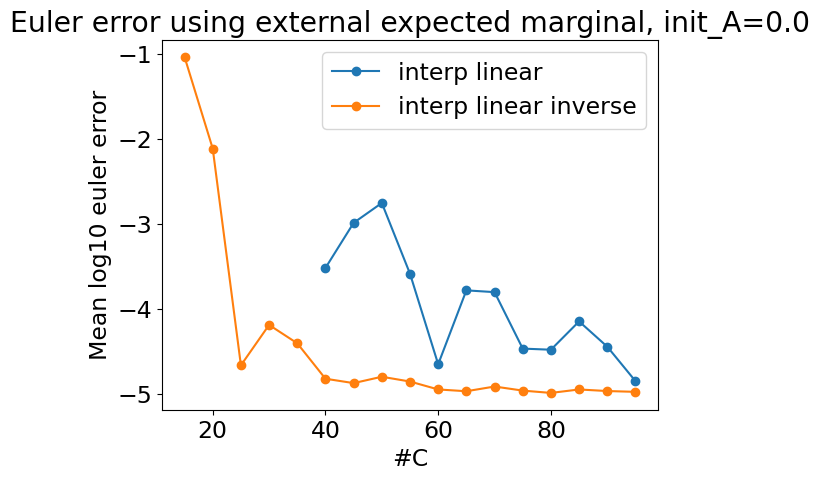

In [12]:
plt.plot(num_marg_u_true0['interp linear'], euler_error_true0['interp linear'], label='interp linear', marker='o')
plt.plot(num_marg_u_true0['interp linear inverse'], euler_error_true0['interp linear inverse'], label='interp linear inverse', marker='o')
plt.legend()
plt.ylabel('Mean log10 euler error')
plt.xlabel('#C')
plt.title('Euler error using external expected marginal, init_A=0.0')

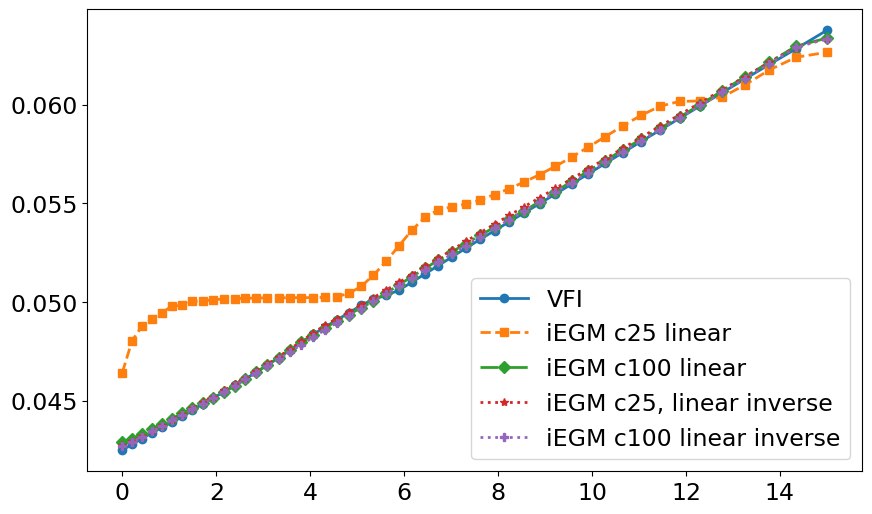

In [13]:
# plot model solutions
grid = 'grid_A'
var = 'power_idx'
var = 'Cw_priv_couple_to_couple'
t = 0
iP = 2
iL = 1
iA = 21

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 0
for name, model in models.items():
    
    par = model.par
    sol = model.sol

    ax.plot(getattr(par,grid), getattr(sol,var)[t,iP,iL], label=model.spec['latexname'], linestyle=linestyles[i], marker=markers[i], linewidth=linewidth)
    i = min(6,i + 1)
ax.legend()


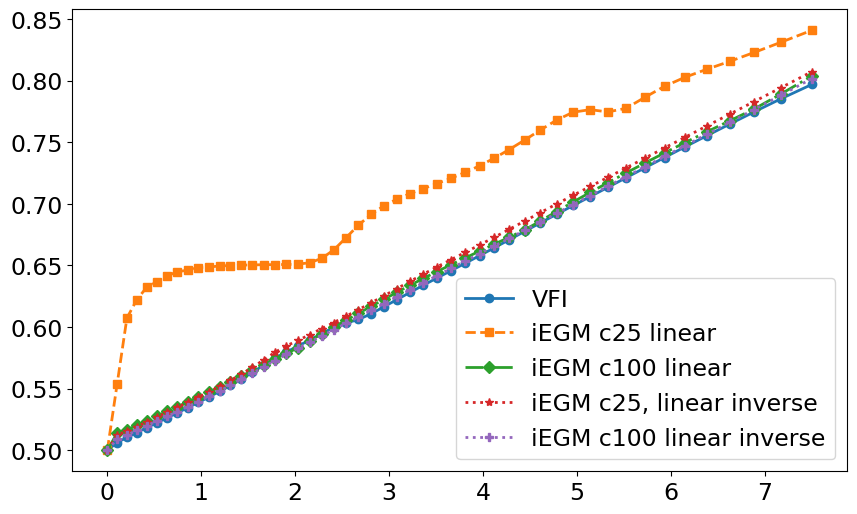

In [14]:
# plot model solutions
grid = 'grid_Aw'
var = 'Cw_priv_single_to_single'

t = 4

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 0
for name, model in models.items():
    
    par = model.par
    sol = model.sol

    ax.plot(getattr(par,grid), getattr(sol,var)[t], label=model.spec['latexname'], linestyle=linestyles[i], marker=markers[i], linewidth=linewidth)
    i =min(6,i+ 1)
ax.legend()

In [17]:
# Re-compile and solve
for model in models.values():
    model.cpp.delink()

recompile = True
for name in models.keys():
    models[name].link_to_cpp(force_compile=recompile)

    print(f'\nsolving {name}...')
    models[name].allocate()
    %time models[name].solve()
    
    recompile = False



solving model 1...
CPU times: total: 34.1 s
Wall time: 1.81 s

solving model 2...
CPU times: total: 3.06 s
Wall time: 222 ms

solving model 3...
CPU times: total: 4.34 s
Wall time: 218 ms

solving model 4...
CPU times: total: 2.84 s
Wall time: 208 ms

solving model 5...
CPU times: total: 3.61 s
Wall time: 209 ms


## Monte Carlo runs

In [63]:
MC_num = 1 # number of Monte Carlo simulations
C_num_grid = (20,50,100,200) # number of grid points in consumption grid i iEGM

specs = {'centered_gradient':True, 
       'p_meet': 0.1, 
       'div_A_share': 0.5, 
       'sigma_love':0.1,
       'T':20,
       'do_cpp':True,
       'threads':50,
       'simT':T,
       'simN': 500,
       'use_external_solution':True,
       }

In [64]:
PRINT = True
# setup Monte Carlo results containers
timing = {
    'vfi':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
error = {
    'vfi':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
for i_c,num_C in enumerate(C_num_grid):
    timing['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)

In [65]:
# loop over Monte Carlo simulations
for i_mc in range(MC_num):
    if PRINT: print(f'{i_mc+1}/{MC_num} running...')
    model = lcm.HouseholdModelClass(par=specs)

    model.par.seed = i_mc
    model.allocate()
    model.set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

    model.link_to_cpp(force_compile=False)

    # VFI
    model.par.do_egm = False
    
    # Timing
    t0 = time()
    model.solve()
    timing['vfi'][i_mc] = time() - t0

    # Euler error
    model.simulate()
    error['vfi'][i_mc] = model.sim.mean_log10_euler

    # iEGM
    model.par.do_egm = True
    for interp_inverse in (False,True):
        model.par.interp_inverse = interp_inverse
        method = f'iegm, linear inverse' if interp_inverse else 'iegm, linear'
        for i_c,num_C in enumerate(C_num_grid):
            model.par.num_marg_u = num_C

            model.allocate()
            model.set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

            # Timing
            t0 = time()
            model.solve()
            timing[method][num_C][i_mc] = time() - t0

            # Euler error
            model.simulate()
            error[method][num_C][i_mc] = model.sim.mean_log10_euler

# save MC objects
with open('output/MC_timing.pkl', 'wb') as f:
    pickle.dump(timing, f)
with open('output/MC_error.pkl', 'wb') as f:
    pickle.dump(error, f)

1/1 running...


In [66]:
print('Euler Error & Timing (rel. to VFI)')
timing_vfi = np.mean(timing['vfi'])
for method in ('vfi',):
    error_now = np.mean(error[method])
    time_now = np.mean(timing[method]) / timing_vfi
    print(f'{method}: {error_now:2.3f} & {time_now:2.3f} ')

for method in ('iegm, linear','iegm, linear inverse'):
    print(f'{method}: ')
    for i_c,num_C in enumerate(C_num_grid):
        error_now = np.mean(error[method][num_C]) 
        time_now = np.mean(timing[method][num_C]) / timing_vfi
        print(f'{num_C:d} {error_now:2.3f} & {time_now:2.3f} ')

Euler Error & Timing (rel. to VFI)
vfi: -18.594 & 1.000 
iegm, linear: 
20 -16.941 & 0.125 
50 -17.400 & 0.113 
100 -18.361 & 0.113 
200 -18.491 & 0.103 
iegm, linear inverse: 
20 -17.500 & 0.096 
50 -18.934 & 0.109 
100 -18.552 & 0.096 
200 -18.444 & 0.114 
